In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import lec7_graphs as gfx
import warnings
from scipy import spatial
from sklearn.datasets import make_blobs
import factor_analyzer as fact
import missingno as msngo

warnings.filterwarnings(action="ignore")
plt.style.use('seaborn')

# Aprendizaje No supervisado

El aprendizaje no supervisado tiene datos sin etiquetar (No hay label o vector objetivo) que el algoritmo tiene que intentar entender por sí mismo.
Las tareas a resolver por este aprendizaje son las siguientes:
- Reducción de dimensionalidad
- Clustering

### Maldición de la dimensionalidad

Text(0.5, 1.0, 'D = 100')

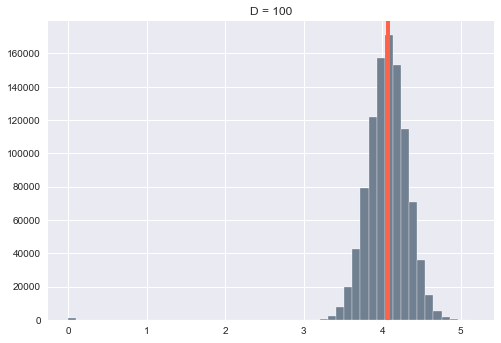

In [8]:
n_dims = 100

# Simulo 1000 muestras con n_dims dimensiones(columnas)
sim_data = np.random.uniform(size=n_dims * 1000).reshape((1000, n_dims))
# Calculo la distancia entre las muestras vs todas las demás muestras
fetch_data = spatial.distance.cdist(sim_data, sim_data, metric='euclidean')
tmp = pd.Series(fetch_data.reshape(1000*1000))
# Genero un histograma de las distancias
plt.hist(tmp, bins=50, ec='white', color='slategrey')
plt.axvline(np.mean(tmp), color='tomato', lw=4, label='Distancia Promedio')
plt.title("D = {}".format(n_dims))

## Factores latentes

1. Definimos una batería de preguntas: Observamos la escala de los datos. Si las escalas son heterogéneos, podemos estandarizar.
2. Eliminamos / imputamos valores perdidos.
3. Generamos métricas de validación.
4. Evaluamos la cantidad de factores.
5. Inferimos características de los factores

In [36]:
df = pd.read_csv('cep45.csv')
trust_df = df.filter(regex="p17_*")
df.shape

(1503, 188)

Cada una de estas preguntas se evaluó en una escala entre:
- 1 (Mucha Confianza)
- 2 (Bastante Confianza)
- 3 (No Mucha Confianza)
- 4 (Ninguna Confianza)

Las categorías 8 (No sabe), 9 (No contesta) representan valores perdidos.

In [37]:
trust_df = trust_df.rename(columns={'p17_a': 'I.Catolica',
                                    'p17_b':'I.Evangelica',
                                    'p17_c': 'FFAA',
                                    'p17_d': 'Justicia',
                                    'p17_e': 'Prensa',
                                    'p17_f': 'Television',
                                    'p17_g':'Sindicatos',
                                    'p17_h':'Carabineros',
                                    'p17_i': 'Gobierno',
                                    'p17_j': 'PartidosPol',
                                    'p17_k': 'Congreso',
                                    'p17_l':'Empresas',
                                    'p17_m':'Universidades',
                                    'p17_n':'Radio'})

In [38]:
trust_df.replace([8, 9], [np.nan, np.nan]).isna().mean().round(2)

I.Catolica       0.03
I.Evangelica     0.07
FFAA             0.04
Justicia         0.04
Prensa           0.03
Television       0.02
Sindicatos       0.09
Carabineros      0.02
Gobierno         0.03
PartidosPol      0.03
Congreso         0.05
Empresas         0.04
Universidades    0.07
Radio            0.03
dtype: float64

In [12]:
#msngo.matrix(trust_df);

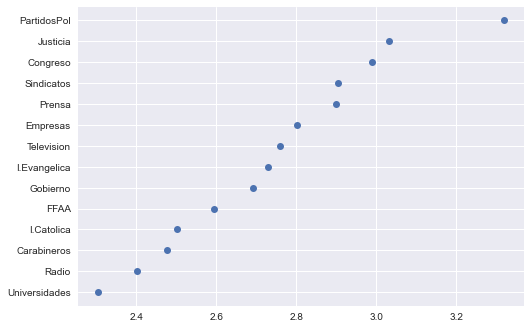

In [6]:
df_mean = trust_df.replace([8, 9],
            [np.nan, np.nan]).mean().reset_index().rename(columns={'index':'var',
                                                                   0:'mean'}).sort_values('mean')
plt.plot(df_mean['mean'], df_mean['var'],'o')

### Prueba de Bartlett
- Ho: La matriz de correlaciones es una matriz de identidad 
- Ha: La materiz de correlaciones no es una matriz de identidad

In [8]:
statistic, pvalor = fact.calculate_bartlett_sphericity(trust_df)
statistic, pvalor

(6644.835705911944, 0.0)

### Prueba de Kaise-Meyer-Olkin (KMO)
- Hay correlaciones mayores a 0 entre las diferentes variables

In [9]:
fact.calculate_kmo(trust_df)

(array([0.93853431, 0.92717654, 0.93176781, 0.95285454, 0.91971575,
        0.88552639, 0.93671982, 0.91120486, 0.93981619, 0.91291311,
        0.91928052, 0.94234885, 0.95178434, 0.93221226]),
 0.9274657194111268)

In [15]:
random_dataset = pd.DataFrame(np.random.rand(1000, 3))
print(pd.DataFrame(random_dataset.corr()))
fact.calculate_kmo(random_dataset)

          0         1         2
0  1.000000  0.005582 -0.012865
1  0.005582  1.000000 -0.020582
2 -0.012865 -0.020582  1.000000


(array([0.5069019 , 0.50267366, 0.50194613]), 0.5029925755101777)

### Análisis de Factores

In [22]:
#help(factorize.get_eigenvalues)

In [30]:
factorize = fact.FactorAnalyzer(n_factors=2)
factorize.fit(trust_df)

factor_screeplot = factorize.get_eigenvalues()[0]

In [31]:
factor_screeplot

array([5.49842419, 1.14587292, 0.89926341, 0.85550809, 0.72165128,
       0.69572011, 0.63389523, 0.62396403, 0.60609083, 0.57058745,
       0.49919319, 0.46208615, 0.40448333, 0.38325979])

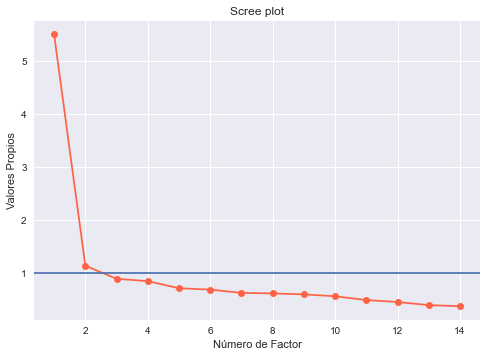

In [32]:
# graficamos los eigenvalues contra la cantidad de dimensiones estimables
plt.plot(range(1, factor_screeplot.shape[0] + 1), factor_screeplot, 'o-', color='tomato')
plt.xlabel('Número de Factor')
plt.ylabel('Valores Propios')
# visualizamos el criterio de corte
plt.axhline(1)
plt.title("Scree plot");

In [33]:
factor_loadings = factorize.loadings_
print(factor_loadings.shape)
print(factor_loadings)

(14, 2)
[[-0.00606221  0.53097319]
 [ 0.06578969  0.31599553]
 [ 0.34283819  0.3281199 ]
 [ 0.45383652  0.19986892]
 [ 0.22914628  0.45086225]
 [-0.14495463  0.83269492]
 [ 0.58749125 -0.06519098]
 [-0.00678929  0.62601667]
 [ 0.42493375  0.30851975]
 [ 0.74100403 -0.01945788]
 [ 0.86817912 -0.15757661]
 [ 0.58873066  0.07625493]
 [ 0.40397717  0.18097999]
 [-0.01982071  0.6363569 ]]


In [23]:
factor_loadings = pd.DataFrame(factor_loadings)
factor_loadings.columns = ['Factor1','Factor2']
factor_loadings.index = trust_df.columns
factor_loadings.applymap(lambda x: np.where(x < .4, ' ', round(x, 2)))

,Factor1,Factor2
I.Catolica,,0.53
I.Evangelica,,
FFAA,,
Justicia,0.45,
Prensa,,0.45
Television,,0.83
Sindicatos,0.59,
Carabineros,,0.63
Gobierno,0.42,
PartidosPol,0.74,


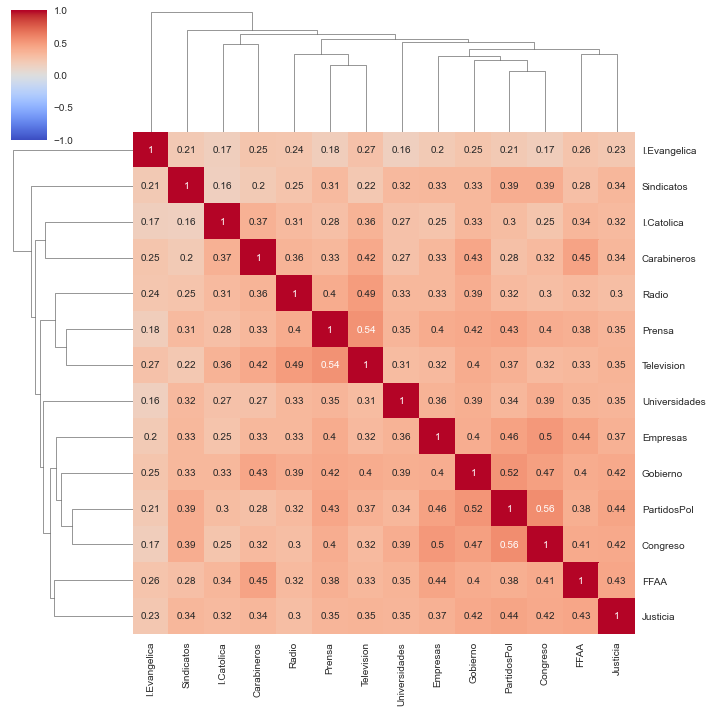

In [39]:
sns.clustermap(trust_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [34]:
#sns.clustermap(trust_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

Text(0, 0.5, 'Factor 2: 0.17')

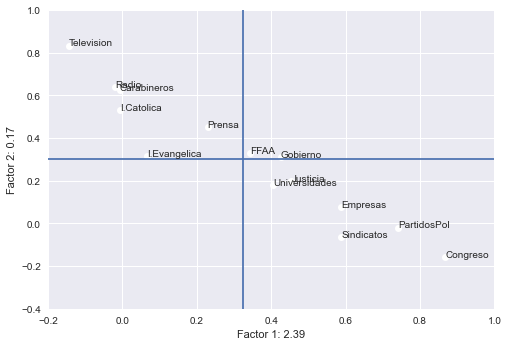

In [25]:
factor_var = factorize.get_factor_variance()

plt.plot(factor_loadings.Factor1, factor_loadings.Factor2,'o',color='white')
plt.xlim((-.2,1)) 
plt.ylim((-.4, 1))

for i, txt in enumerate(factor_loadings.index):
    plt.annotate(txt, (factor_loadings['Factor1'][i], factor_loadings['Factor2'][i]))

plt.axvline(factor_loadings['Factor1'].mean())
plt.axhline(factor_loadings['Factor2'].mean())

plt.xlabel('Factor 1: {}'.format(round(factor_var[0][1], 2)))
plt.ylabel('Factor 2: {}'.format(round(factor_var[1][1], 2)))

In [42]:
extract_factor_scores.shape

(1503, 2)

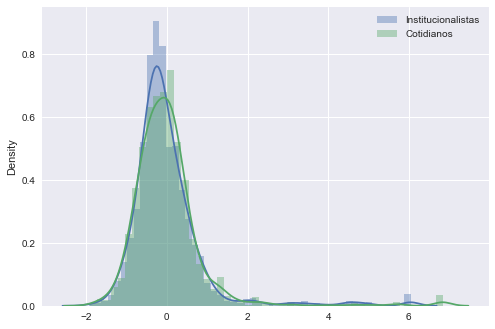

In [40]:
extract_factor_scores = factorize.transform(trust_df)
sns.distplot(extract_factor_scores[:,0], label="Institucionalistas") # Institucionalistas
sns.distplot(extract_factor_scores[:,1], label="Cotidianos") # Cotidianos
plt.legend()

## PCA (análisis de componentes principales)

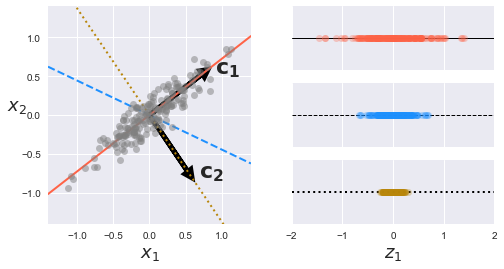

In [43]:
gfx.pca_variance()

In [45]:
import sklearn.datasets
help(sklearn.datasets)

Help on package sklearn.datasets in sklearn:

NAME
    sklearn.datasets

DESCRIPTION
    The :mod:`sklearn.datasets` module includes utilities to load datasets,
    including methods to load and fetch popular reference datasets. It also
    features some artificial data generators.

PACKAGE CONTENTS
    _arff_parser
    _base
    _california_housing
    _covtype
    _kddcup99
    _lfw
    _olivetti_faces
    _openml
    _rcv1
    _samples_generator
    _species_distributions
    _svmlight_format_fast
    _svmlight_format_io
    _twenty_newsgroups
    data (package)
    descr (package)
    images (package)
    setup
    tests (package)

FUNCTIONS
    clear_data_home(data_home=None)
        Delete all the content of the data home cache.
        
        Parameters
        ----------
        data_home : str, default=None
            The path to scikit-learn data directory. If `None`, the default path
            is `~/sklearn_learn_data`.
    
    dump_svmlight_file(X, y, f, *, zero_based

In [47]:
from sklearn.datasets import load_digits
df = load_digits()
df

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

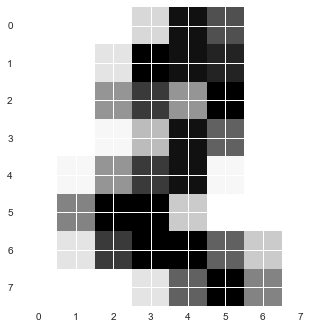

In [48]:
plt.imshow(df.data[2].reshape([8, 8]))

In [49]:
df.target[2]

2

In [33]:
print("Dimensión original de la base:",df.data.shape)

Dimensión original de la base: (1797, 64)


In [50]:
from sklearn.decomposition import PCA

dimred = PCA(n_components = 2) # Cantidad de componentes
project_x = dimred.fit_transform(df.data)
print("La nueva dimensión de la base es de:",project_x.shape)

La nueva dimensión de la base es de: (1797, 2)


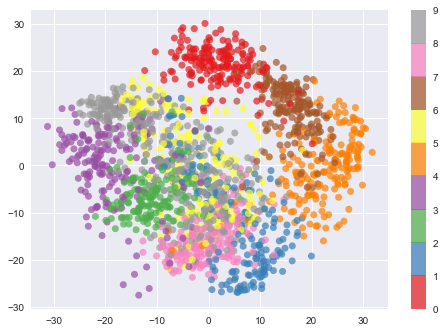

In [51]:
plt.scatter(project_x[:, 0], project_x[:, 1],
c=df.target, edgecolor='none', alpha=.7, cmap='Set1')
plt.colorbar()

In [52]:
print("La varianza explicada de cada dimensión es de:",dimred.explained_variance_ratio_)
print("En conjunto, ambas dimensiones explican la varianza en un: ", sum(dimred.explained_variance_ratio_))

La varianza explicada de cada dimensión es de: [0.14890594 0.13618771]
En conjunto, ambas dimensiones explican la varianza en un:  0.28509364823697825


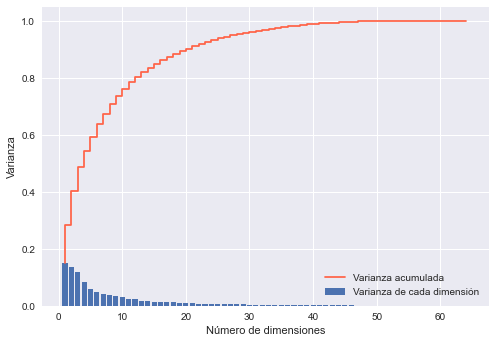

In [52]:
fetch_dims = PCA().fit(df.data)
dims_quant = len(fetch_dims.components_)
plt.bar(range(1, dims_quant + 1),fetch_dims.explained_variance_ratio_,label="Varianza de cada dimensión")
plt.step(range(1,len(fetch_dims.components_) + 1),
         np.cumsum(fetch_dims.explained_variance_ratio_),
         color='tomato',label="Varianza acumulada")
plt.xlabel('Número de dimensiones')
plt.ylabel('Varianza')
plt.legend()

In [62]:
n = 13
pca = PCA(n_components=n)
project_x = pca.fit_transform(df.data)
print(f"Varianza acumulada con {n} dimensiones:", np.cumsum(pca.explained_variance_ratio_)[-1])


Varianza acumulada con 13 dimensiones: 0.8028940711994053


## Clustering (Kmeans)

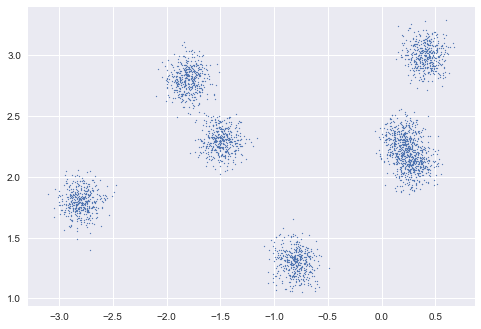

In [53]:
from sklearn.datasets import make_blobs

bivariate_mu_params = list([[ 0.2, 2.3], 
                            [-1.5 , 2.3],
                            [-2.8, 1.8], 
                            [-1.8, 2.8], 
                            [-.8, 1.3],
                            [.3, 2.1], 
                            [.4, 3]])
bivariate_sigma_params = list([.1, .1, .1, .1, .1, .1, .1])
X_mat, y_vec = make_blobs(n_samples=3000,
                          centers=bivariate_mu_params,
                          cluster_std=bivariate_sigma_params,
                          random_state=11238)

plt.scatter(X_mat[:, 0], X_mat[:, 1], s=1)

In [61]:
!python -m pip freeze

-ffi @ file:///C:/ci/cffi_1600699246375/work
absl-py==1.1.0
alabaster==0.7.12
altair==4.2.0
anaconda-client==1.7.2
anaconda-navigator==1.10.0
anaconda-project==0.8.3
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1596828585465/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1592487315634/work
astropy==4.0.2
astunparse==1.6.3
async-generator==1.10
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
audioread==2.1.9
autopep8 @ file:///tmp/build/80754af9/autopep8_1596578164842/work
autoviz==0.0.81
Babel @ file:///tmp/build/80754af9/babel_1605108370292/work
backcall==0.2.0
backports.functools-lru-cache==1.6.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
backports.zoneinfo==0.2.1
bcrypt @ file:///C:/ci/bcrypt_1597936263757/work
beautifulsoup4 @ file:///tmp/build/80754af9/beautifulsoup4_1601924105527/work
bitarray @ file:///C:/ci/bitarr

In [54]:
from sklearn.cluster import KMeans
import pandas as pd


kmeans = KMeans(n_clusters=6, random_state=11238)
fit_results = kmeans.fit_predict(X_mat)

In [55]:
pd.Series(kmeans.labels_).value_counts('%')

2    0.285667
5    0.143667
3    0.143000
1    0.142667
4    0.142667
0    0.142333
dtype: float64

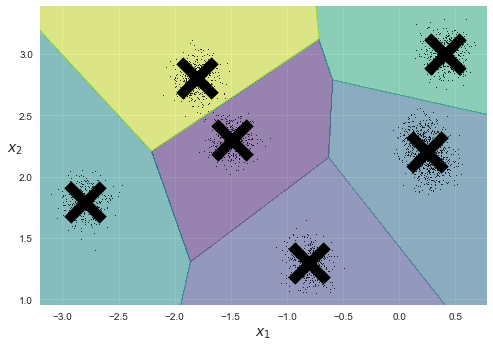

In [72]:
gfx.plot_decision_boundaries(kmeans, X_mat)

In [56]:
kmeans.inertia_

69.05074506590341

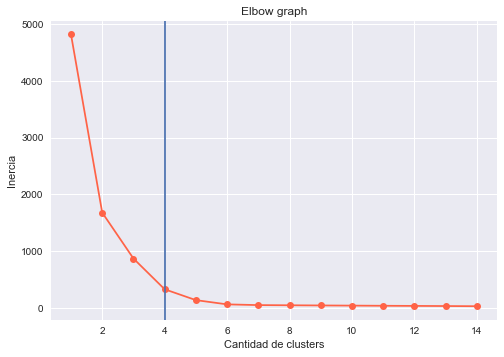

In [57]:
inertia = []
n_test = 15
for i in range(1, n_test):
    inertia.append(KMeans(n_clusters=i, random_state=11238).fit(X_mat).inertia_)
    
plt.plot(range(1, n_test), inertia, 'o-', color='tomato')
plt.xlabel("Cantidad de clusters")
plt.ylabel("Inercia")
plt.title("Elbow graph")
plt.axvline(4)

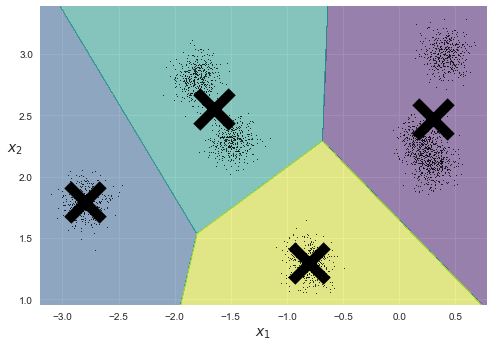

In [58]:
kmeans = KMeans(n_clusters=4, random_state=11238)
fit_results = kmeans.fit_predict(X_mat)
gfx.plot_decision_boundaries(kmeans, X_mat)

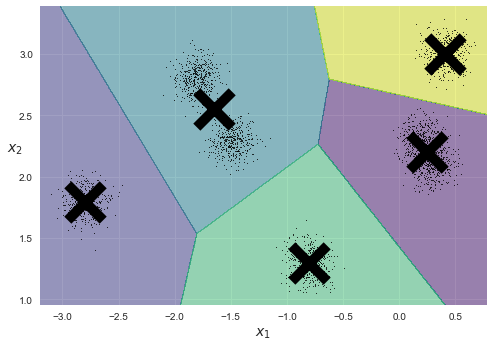

In [77]:
kmeans = KMeans(n_clusters=5, random_state=11238)
fit_results = kmeans.fit_predict(X_mat)
gfx.plot_decision_boundaries(kmeans, X_mat)

In [59]:
init_1 = KMeans(n_clusters=7, random_state=5342, init="random", n_init=1)
init_1.fit(X_mat)
init_2 = KMeans(n_clusters=7, random_state=138, init="random", n_init=1)
init_2.fit(X_mat)

KMeans(init='random', n_clusters=7, n_init=1, random_state=138)

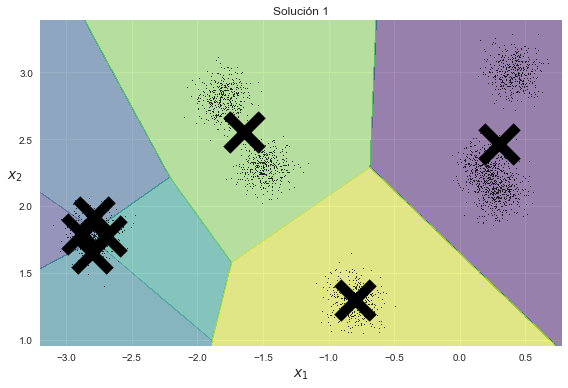

In [60]:
gfx.plot_decision_boundaries(init_1, X_mat)
plt.title('Solución 1')
plt.tight_layout()